In [1]:
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Visualization (for inspection)
import matplotlib.pyplot as plt
import seaborn as sns


# Cleaning


In [10]:
# Load CSV file
df = pd.read_csv("mymoviedb.csv",engine='python')

# Quick look
df.head()


,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793,7.0,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...


In [11]:
print(df.shape)
df.info()


(9837, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9837 entries, 0 to 9836
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Release_Date       9837 non-null   object 
 1   Title              9828 non-null   object 
 2   Overview           9828 non-null   object 
 3   Popularity         9827 non-null   float64
 4   Vote_Count         9827 non-null   object 
 5   Vote_Average       9827 non-null   object 
 6   Original_Language  9827 non-null   object 
 7   Genre              9826 non-null   object 
 8   Poster_Url         9826 non-null   object 
dtypes: float64(1), object(8)
memory usage: 691.8+ KB


In [12]:
df.isnull().sum()

Release_Date          0
Title                 9
Overview              9
Popularity           10
Vote_Count           10
Vote_Average         10
Original_Language    10
Genre                11
Poster_Url           11
dtype: int64

In [16]:
df = df.dropna(subset=["Title", "Overview", "Genre"])
df["Overview"] = df["Overview"].astype(str)
df = df.drop_duplicates(subset=["Title","Release_Date"])

print("Cleaned dataset size:", df.shape)



Cleaned dataset size: (9512, 9)


# Text Preprocessing

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text) 
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)


In [19]:
df["clean_overview"] = df["Overview"].apply(clean_text)
df["clean_genre"] = df["Genre"].apply(clean_text)


In [23]:
df["movie_profile"] = df["clean_overview"] + " " + df["clean_genre"]


df[["Title", "movie_profile"]].head()


,Title,movie_profile
0,Spider-Man: No Way Home,peter parker unmasked longer able separate nor...
1,The Batman,second year fighting crime batman uncovers cor...
2,No Exit,stranded rest stop mountain blizzard recoverin...
3,Encanto,tale extraordinary family madrigal live hidden...
4,The King's Man,collection history worst tyrant criminal maste...


# TF-IDF

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [28]:
tfidf = TfidfVectorizer(
    max_features=10000,   # limit vocabulary size
    ngram_range=(1, 2),   # unigrams + bigrams
    min_df=3              # ignore very rare words
)

tfidf_matrix = tfidf.fit_transform(df["movie_profile"])
print("TF-IDF matrix shape:", tfidf_matrix.shape)



TF-IDF matrix shape: (9512, 10000)


In [33]:
tfidf.get_feature_names_out()[:100]


array(['aaron', 'abandon', 'abandoned', 'abby', 'abduct', 'abducted',
       'abduction', 'abducts', 'abe', 'abigail', 'ability', 'able',
       'able save', 'aboard', 'abraham', 'abroad', 'abrupt', 'absence',
       'absolute', 'absolutely', 'absurd', 'abuse', 'abused', 'abusive',
       'academic', 'academy', 'accept', 'acceptance', 'accepted',
       'accepts', 'access', 'accident', 'accident leaf', 'accidental',
       'accidental death', 'accidentally', 'accidentally kill',
       'acclaimed', 'accompanied', 'accompanies', 'accompany',
       'accompanying', 'accomplice', 'accomplish', 'accomplished',
       'according', 'account', 'accountant', 'accused', 'accused killing',
       'accused murder', 'accused murdering', 'ace', 'achieve',
       'achieved', 'acquaintance', 'acre', 'acre wood', 'across',
       'across america', 'across country', 'across globe',
       'across street', 'act', 'act violence', 'acting', 'action',
       'action adventure', 'action animation', 'action 

# PCA

In [34]:
from sklearn.decomposition import TruncatedSVD


In [66]:
n_components = 200  # good trade-off

svd = TruncatedSVD(n_components=n_components, random_state=42)
pca_features = svd.fit_transform(tfidf_matrix)



In [67]:
explained_variance = svd.explained_variance_ratio_
print("Total explained variance:", explained_variance.sum())


Total explained variance: 0.19799072951910582


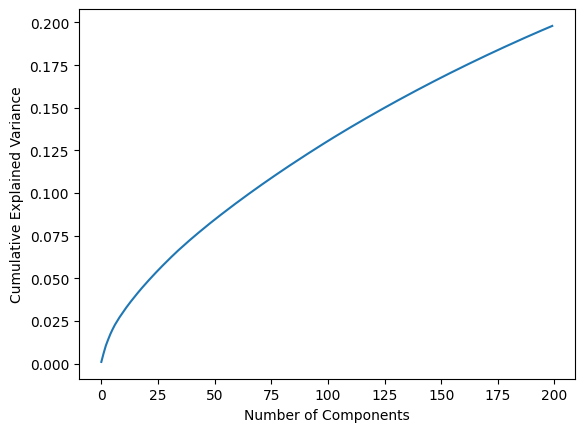

In [68]:
plt.plot(np.cumsum(explained_variance))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()


# GMM

In [69]:
from sklearn.mixture import GaussianMixture


In [70]:
bic_scores = []
aic_scores = []
k_range = range(1, 31)  # try 5 → 30 clusters

for k in k_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(pca_features)
    bic_scores.append(gmm.bic(pca_features))
    aic_scores.append(gmm.aic(pca_features))


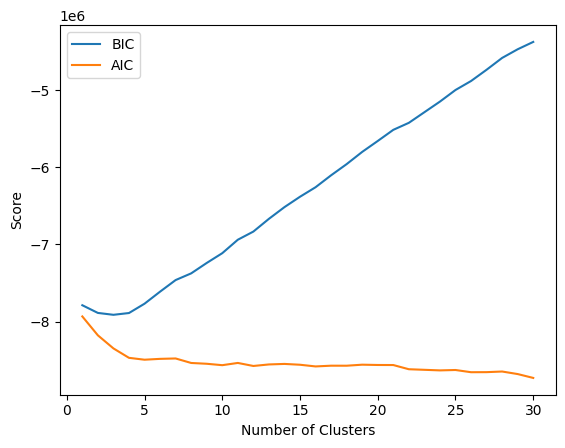

In [71]:
plt.plot(k_range, bic_scores, label="BIC")
plt.plot(k_range, aic_scores, label="AIC")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.show()


In [76]:
optimal_k = 10

gmm = GaussianMixture(
    n_components=optimal_k,
    covariance_type="full",
    random_state=42
)

gmm_labels = gmm.fit_predict(pca_features)


In [77]:
df["gmm_cluster"] = gmm_labels
gmm_probs = gmm.predict_proba(pca_features)
for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id}")
    sample_titles = df[df["gmm_cluster"] == cluster_id]["Title"].head(20)
    print(sample_titles.tolist())




Cluster 0
['Resident Evil: Welcome to Raccoon City', 'Blacklight', "Ron's Gone Wrong", 'Mother/Android', 'AI Love You', 'Infinite', 'Meander', 'Apex', 'Dragon Fury', 'Knowing', 'The Maze Runner', 'Monster Hunter', 'Bigbug', 'Real Steel', "Don't Look Up", 'A Quiet Place Part II', 'Jurassic Hunt', 'Mutation on Mars', 'Zone 414', '7 Prisoners']

Cluster 1
['Marry Me', 'Through My Window', "Tyler Perry's A Madea Homecoming", 'Cruella', 'After We Fell', 'Sex, Shame and Tears 2', 'Heart Shot', 'UFO', 'The Fallout', 'The Royal Treatment', 'Love Tactics', 'After We Collided', 'The Sky Is Everywhere', 'Time Is Up', 'Ava', 'Love and Leashes', 'After', 'Tall Girl 2', 'Yes, No, or Maybe Half?', 'Book of Love']

Cluster 2
['No Exit', 'Scream', 'Texas Chainsaw Massacre', 'The Requin', 'The Jack in the Box: Awakening', 'Ghostbusters: Afterlife', 'The Hunting', 'Desperate Riders', 'Brazen', 'The Privilege', 'Queen of Spades', 'Antlers', 'Dangerous', 'No Time to Die', 'Two', 'Dark Spell', 'The Weekend